In [ ]:
#@title Install prerequsite

!pip install lifelines

In [ ]:


from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predicting Progression Free Survival of TCGA NSCLC Patients: Getting Started


## Exploratory data analysis (EDA)


* `clinical_train`: Clinical information of each patient in the trianing set
* `clinical_test`: Clinical information of each patient in the test set
* `rnaseq_train`: Normalized voom values of RNASeq data of each patient in the trianing set
* `rnaseq_test`: Normalized voom values of RNASeq data of each patient in the test set
* `mut_train`: Mutation information as MAF file format of each patient in the training set
* `mut_test`: Mutation information as MAF file format of each patient in the test set
* `pfs_train`: Progression-free survival of each patient in the training set. 

In [ ]:
from pathlib import Path

# Change this to where you download the files
DATA = Path("/content/drive/My Drive/2019 ECBM E4060/mini-challenge/data")

### Progression-free survival


In [ ]:
import pandas as pd

pfs_train = pd.read_csv(DATA / "pfs_train.txt", sep="\t", index_col="patient_id")
pfs_train.head()

,progression,time_to_progression_or_censor
patient_id,,
TRAIN_0000,1.0,334.0
TRAIN_0001,0.0,1523.0
TRAIN_0002,0.0,121.0
TRAIN_0003,1.0,334.0
TRAIN_0004,1.0,183.0


In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(pfs_train.time_to_progression_or_censor, pfs_train.progression)

<lifelines.KaplanMeierFitter: fitted with 816 total observations, 525 right-censored observations>

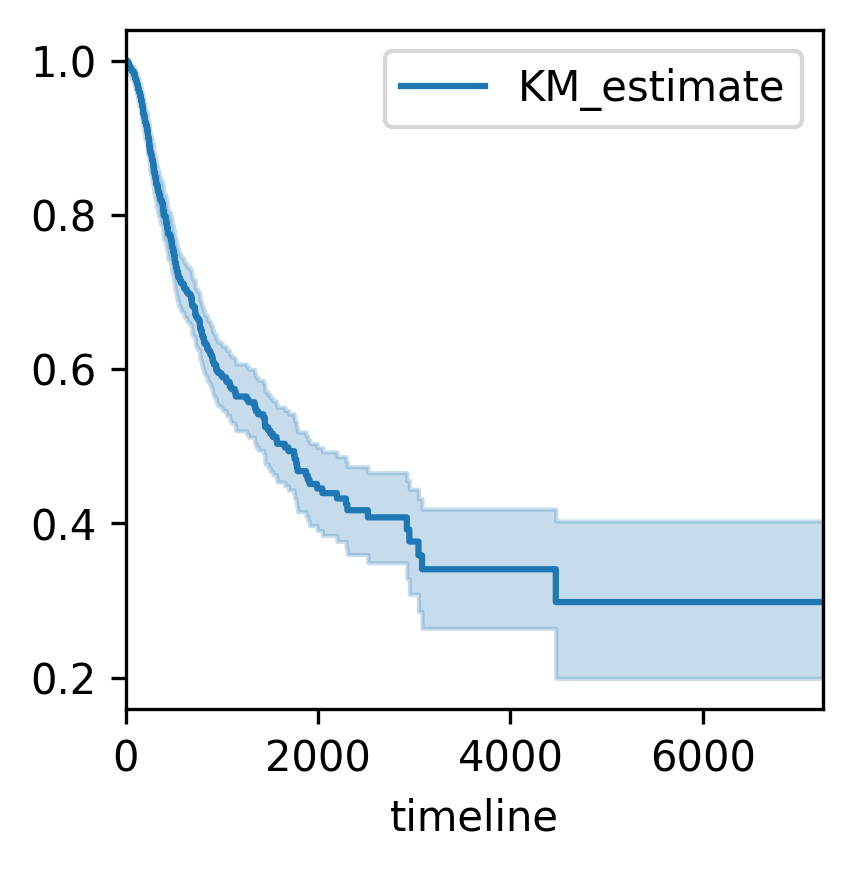

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=300, figsize=(3, 3))
kmf.plot(ax=ax)

In [ ]:
print("Median survival time of the population is {}".format(
    kmf.median_survival_time_)
)

Median survival time of the population is 1655.0


### Clinical data


In [ ]:
clin_train = pd.read_csv(DATA / "clinical_train.txt", sep="\t", index_col="patient_id")

# also load clin_test
clin_test = pd.read_csv(DATA / "clinical_test.txt", sep="\t", index_col="patient_id")

clin_train.head()

,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision,diagnosis,eastern_cancer_oncology_group,ethnicity,gender,karnofsky_performance_score,laterality,location_in_lung_parenchyma,number_pack_years_smoked,pathologic_M,pathologic_N,pathologic_T,pathologic_stage,race,radiation_therapy,residual_tumor,tobacco_smoking_history
patient_id,,,,,,,,,,,,,,,,,,
TRAIN_0000,81,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],32,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0001,67,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],Peripheral Lung,52,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,3
TRAIN_0002,79,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],FEMALE,[Not Available],[Not Available],[Not Available],47,M0,N1,T3,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0003,68,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],62,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,4
TRAIN_0004,66,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],20,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],RX,3


In [ ]:
# First construct a data frame with all the variables needed
mat = pd.concat([pfs_train.copy(), clin_train[["diagnosis"]]],
                axis=1, sort=True)
# convert the diagnosis to whether the patient is LUAD
mat["diagnosis"] = mat.diagnosis == "Lung Adenocarcinoma"
mat.rename(columns={"diagnosis": "LUAD"}, inplace=True)

mat.head()

,progression,time_to_progression_or_censor,LUAD
patient_id,,,
TRAIN_0000,1.0,334.0,True
TRAIN_0001,0.0,1523.0,True
TRAIN_0002,0.0,121.0,True
TRAIN_0003,1.0,334.0,True
TRAIN_0004,1.0,183.0,True


In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')

<lifelines.CoxPHFitter: fitted with 816 total observations, 525 right-censored observations>

In [ ]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
LUAD,0.43944,1.551838,0.119613,0.205002,0.673878,1.227527,1.96183,3.673836,0.000239,12.031086


In [ ]:
print("The concordance index between tumor type and PFS is {:.4f}".format(
    1 - cph.score_
))

The concordance index between tumor type and PFS is 0.4498


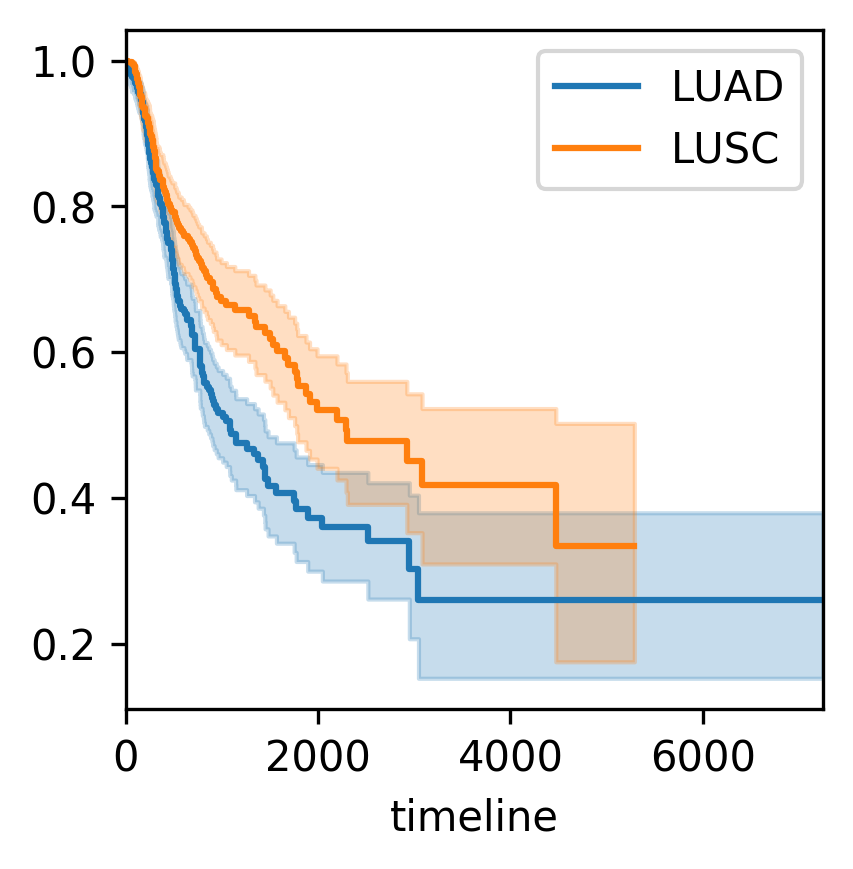

In [ ]:
fig, ax = plt.subplots(dpi=300, figsize=(3, 3))

luad_idx = mat.LUAD
kmf.fit(mat.time_to_progression_or_censor[luad_idx], mat.progression[luad_idx],
        label="LUAD")
kmf.plot(ax=ax)
kmf.fit(mat.time_to_progression_or_censor[~luad_idx],
        mat.progression[~luad_idx],
        label="LUSC")
kmf.plot(ax=ax)

In [ ]:
def cat_cont_summary_for_col(col: pd.Series, cat_cutoff: int):
    """Given a :class:`pandas.Series`, calculate its cardinality, and if its
    continuous, show summary statistics; if categorical, show unique values
    
    Arguments
    ---------
    col: pandas.Series
        Input series
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_info: dict
        A dictionary containing info regarding the input series. If the series
    """
    card = col.nunique()
    col_type = "cat" if card <= cat_cutoff else "cont"
    if col_type == "cont":
        col = pd.to_numeric(col, errors="coerce")
    else:
        col = col.astype(str)

    col_info = {
        "cardinality": card,
        "col_type": col_type,
        **col.describe()
    }
    if col_type == "cat":
        col_info["unique_values"] = col.unique()

    return col_info


def cat_cont_summary_for_df(df: pd.DataFrame, cat_cutoff: int = 20):
    """Given a :class:`pandas.DataFrame`, determine whether each column is
    categorical or continuous, and output its summary statistics
    
    Arguments
    ---------
    df: pandas.DataFrame
        Input data frame
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_summary: pandas.DataFrame
        A :class:`pandas.DataFrame` summarizing the statistics of each column
    """
    col_sums = [cat_cont_summary_for_col(df[col], cat_cutoff)
                for col in df.columns]
    col_summary = pd.DataFrame(col_sums)
    col_summary.index = df.columns.values
    return col_summary

In [ ]:
cat_cont_summary_for_df(clin_train)

,cardinality,col_type,count,mean,std,min,25%,50%,75%,max,unique,top,freq,unique_values
age_at_initial_pathologic_diagnosis,53,cont,801.0,66.224719,9.476652,33.00,60.0,67.00,73.0,88.0,NaN,NaN,NaN,NaN
anatomic_neoplasm_subdivision,9,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,R-Upper,251.0,"[L-Upper, R-Lower, R-Upper, L-Lower, R-Middle,..."
diagnosis,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Lung Adenocarcinoma,413.0,"[Lung Adenocarcinoma, Lung Squamous Cell Carci..."
eastern_cancer_oncology_group,7,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,[Not Available],377.0,"[[Not Available], [Not Evaluated], 1, 0, 3, 2,..."
ethnicity,5,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NOT HISPANIC OR LATINO,575.0,"[[Not Available], NOT HISPANIC OR LATINO, HISP..."
gender,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MALE,492.0,"[MALE, FEMALE]"
karnofsky_performance_score,13,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,[Not Available],507.0,"[[Not Available], 0, [Not Evaluated], 80, 90, ..."
laterality,1,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,[Not Available],816.0,[[Not Available]]
location_in_lung_parenchyma,4,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,[Not Available],358.0,"[[Not Available], Peripheral Lung, Central Lun..."
number_pack_years_smoked,128,cont,622.0,47.547516,28.168011,0.15,28.0,40.25,60.0,180.0,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np

def replace_by_na(col: pd.Series, char: str = "["):
    idx = [char in str(x) for x in col]
    _col = col.copy()
    _col.loc[idx] = np.NaN
    return _col

# perform the same transformation to both clin_train and clin_test
for col in clin_train.columns:
    clin_train[col] = replace_by_na(clin_train[col])
    clin_test[col] = replace_by_na(clin_test[col])


In [ ]:
cat_cont_summary_for_df(clin_train)

,cardinality,col_type,count,mean,std,min,25%,50%,75%,max,unique,top,freq,unique_values
age_at_initial_pathologic_diagnosis,52,cont,801.0,66.224719,9.476652,33.00,60.0,67.00,73.0,88.0,NaN,NaN,NaN,NaN
anatomic_neoplasm_subdivision,7,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,R-Upper,251.0,"[L-Upper, R-Lower, R-Upper, L-Lower, R-Middle,..."
diagnosis,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Lung Adenocarcinoma,413.0,"[Lung Adenocarcinoma, Lung Squamous Cell Carci..."
eastern_cancer_oncology_group,4,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,nan,488.0,"[nan, 1, 0, 3, 2]"
ethnicity,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NOT HISPANIC OR LATINO,575.0,"[nan, NOT HISPANIC OR LATINO, HISPANIC OR LATINO]"
gender,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MALE,492.0,"[MALE, FEMALE]"
karnofsky_performance_score,9,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,nan,664.0,"[nan, 0, 80, 90, 50, 100, 70, 40, 60, 20]"
laterality,0,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,nan,816.0,[nan]
location_in_lung_parenchyma,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,nan,469.0,"[nan, Peripheral Lung, Central Lung]"
number_pack_years_smoked,127,cont,622.0,47.547516,28.168011,0.15,28.0,40.25,60.0,180.0,NaN,NaN,NaN,NaN


In [ ]:
cat_cols = ["diagnosis", "location_in_lung_parenchyma", "pathologic_M",
            "pathologic_N", "pathologic_T", "radiation_therapy",
            "residual_tumor"]
cont_cols = ["age_at_initial_pathologic_diagnosis"]

In [ ]:
# Concatenate categorical variables of interest and numerical variables of
# interest into ml-ready matrices
x_clin_train = pd.concat([pd.get_dummies(clin_train[cat_cols]),
                          clin_train[cont_cols]], axis=1, sort=True)

x_clin_test = pd.concat([pd.get_dummies(clin_test[cat_cols]),
                         clin_test[cont_cols]], axis=1, sort=True)

### RNASeq data


In [ ]:
ge_train = pd.read_csv(DATA / "rnaseq_train.txt", sep="\t", index_col=0)
ge_test = pd.read_csv(DATA / "rnaseq_test.txt", sep="\t", index_col=0)

ge_train.head()

,TRAIN_0001,TRAIN_0002,TRAIN_0003,TRAIN_0004,TRAIN_0005,TRAIN_0006,TRAIN_0007,TRAIN_0008,TRAIN_0009,TRAIN_0010,TRAIN_0011,TRAIN_0012,TRAIN_0013,TRAIN_0014,TRAIN_0015,TRAIN_0016,TRAIN_0017,TRAIN_0018,TRAIN_0019,TRAIN_0020,TRAIN_0021,TRAIN_0022,TRAIN_0023,TRAIN_0024,TRAIN_0025,TRAIN_0026,TRAIN_0027,TRAIN_0028,TRAIN_0029,TRAIN_0030,TRAIN_0031,TRAIN_0032,TRAIN_0033,TRAIN_0034,TRAIN_0035,TRAIN_0036,TRAIN_0037,TRAIN_0038,TRAIN_0039,TRAIN_0040,...,TRAIN_0776,TRAIN_0777,TRAIN_0778,TRAIN_0779,TRAIN_0780,TRAIN_0781,TRAIN_0782,TRAIN_0783,TRAIN_0784,TRAIN_0785,TRAIN_0786,TRAIN_0787,TRAIN_0788,TRAIN_0789,TRAIN_0790,TRAIN_0791,TRAIN_0792,TRAIN_0793,TRAIN_0794,TRAIN_0795,TRAIN_0796,TRAIN_0797,TRAIN_0798,TRAIN_0799,TRAIN_0800,TRAIN_0801,TRAIN_0802,TRAIN_0803,TRAIN_0804,TRAIN_0805,TRAIN_0806,TRAIN_0807,TRAIN_0808,TRAIN_0809,TRAIN_0810,TRAIN_0811,TRAIN_0812,TRAIN_0813,TRAIN_0814,TRAIN_0815
A1BG,-1.3364,-1.7668,-1.0198,-0.8983,-5.9363,0.3527,-3.0055,-2.3069,-2.1904,-1.2656,-1.3568,-0.7001,-2.8087,-1.0790,-1.5845,-1.2057,-1.6855,-1.1610,0.4233,-3.0186,-1.7536,-1.3744,-0.7374,-4.0285,-3.9233,-3.0484,-1.3048,-2.3104,-3.3131,-4.6724,-2.4712,-2.6891,-4.0212,-3.2784,-1.4477,-3.3057,-1.9225,-3.4339,-2.0238,-1.0988,...,-1.5283,-1.3231,-0.9713,-0.9121,-0.9251,-1.0919,0.2249,-0.6211,-3.3718,-2.0011,-0.9321,-1.0119,-1.3776,-1.4497,-2.0486,-3.0911,0.6557,0.4914,-0.1059,1.1786,-1.9261,-0.4090,-0.3578,-1.9184,0.4643,0.5011,-3.6151,-2.0062,-1.6154,-1.8095,-0.3868,0.4650,0.6863,-1.3412,-0.3093,-0.5301,-1.9589,-3.5359,-1.4197,-1.5915
A1BG-AS1,1.7801,0.7311,1.3790,1.4652,-1.1814,2.4569,-0.3547,0.1567,-0.4160,0.1432,1.0081,1.3865,0.2076,0.8685,-0.4850,1.6472,1.0725,2.1088,1.9816,-0.6165,-0.1687,1.0956,2.0803,-0.5321,-0.7533,0.3515,0.6253,1.5405,0.9846,-1.1280,0.6834,0.9465,-1.7841,0.5763,1.3927,-1.0927,0.3995,-1.5358,0.9184,2.0496,...,1.1689,0.9989,1.5540,1.3656,1.4299,0.8419,2.1225,1.1096,-0.4218,1.5061,1.0749,1.8351,0.4968,1.0799,0.6248,-0.1076,2.4359,2.0764,2.0007,3.6502,0.1443,2.3077,1.1210,0.4837,2.2172,2.0787,0.0854,0.3697,0.9461,0.9194,1.0042,2.7258,3.2015,1.5483,2.0472,1.6936,-0.0731,-1.6099,0.9022,0.3975
A1CF,-4.3104,-6.9762,-6.0047,-2.7964,1.4124,-6.1761,-7.6493,-1.7065,-4.1164,-6.1236,-5.4997,-5.0364,-6.2681,-2.1363,0.8936,-3.2891,4.6606,-3.7933,-3.4446,3.3810,-5.8411,-4.2620,-4.7193,-6.8359,-5.5082,-6.2184,-4.9292,-5.1178,-6.4830,-6.2573,-6.8635,-5.4965,-3.6586,-5.6003,-6.6572,-5.1801,-6.9669,-6.8933,-5.5681,-6.5907,...,-3.8503,-6.5325,-4.5958,-6.6400,-5.4486,-6.3773,-3.6819,-2.6421,-5.2462,-6.7560,-3.7972,-6.3695,-5.7699,-4.0819,-5.3216,-6.5505,-5.4528,-6.1668,-2.2473,-1.6288,-3.4595,-4.7548,-4.3275,-3.9888,2.9479,-4.2104,-5.9370,-4.8136,-4.9846,-6.5644,-6.1147,-2.3639,-4.3047,-6.6266,-1.3841,-2.4416,-4.8975,-3.7423,-2.3708,-5.0510
A2M,10.2830,9.7800,10.0746,11.1037,10.1339,9.2526,9.9767,10.8297,7.7219,10.6659,8.2200,9.3291,8.6852,9.4124,10.7804,10.0078,9.1490,9.0152,7.9316,8.7049,10.1049,10.1162,7.5333,7.9038,7.5614,7.7608,7.6639,8.8712,7.0693,7.6023,8.2200,8.7249,7.1395,8.7063,8.2883,7.4633,7.1652,7.1328,10.0292,8.1975,...,10.7359,10.1068,9.7267,9.8094,9.0229,6.3728,7.9693,7.1119,6.3637,10.8858,7.7719,6.7333,6.4983,7.5106,7.8337,6.9946,7.7285,8.4274,9.0582,9.8243,9.1790,9.2028,11.1617,10.0291,10.1678,7.7649,6.6188,6.4436,8.4880,7.7960,5.2123,10.2018,8.2129,8.3069,7.2597,7.9215,7.8997,9.5837,11.1142,9.2260
A2M-AS1,-0.4035,-0.7095,1.2080,-0.2786,-0.3216,-0.6842,-0.4894,-0.6612,1.3232,0.0663,-0.2903,0.2490,0.1413,0.0721,-1.3330,-0.5834,0.8852,0.1136,0.1161,-0.4684,-1.3175,1.4217,-0.1464,0.4215,0.6279,0.7474,-0.0713,1.8011,-0.0736,0.1177,0.8712,1.4693,0.5024,-0.9954,-0.9292,0.6012,0.8973,0.2462,0.3467,-1.2331,...,-0.0878,0.2619,0.5058,0.4580,0.1856,1.3709,0.4428,1.3093,-0.9486,0.8513,1.2220,0.4507,0.7999,0.6074,0.4772,0.6879,-0.3513,-0.1444,-0.9085,-1.1982,-0.3238,0.0353,0.0649,0.1971,0.4249,-1.4879,-0.2091,-1.1131,0.2249,1.2494,0.7054,-0.3080,-0.9542,-1.6724,0.6538,-0.1474,0.6365,0.3054,-0.3004,-0.6586


In [ ]:
mat = pd.concat([pfs_train, ge_train.transpose()], axis=1, sort=True).dropna()

In [ ]:
from tqdm import tqdm
from lifelines.utils import concordance_index

out = []

# calculate concordance index for all genes, THIS WILL TAKE A WHILE
for i in tqdm(range(2, mat.shape[1]), total=mat.shape[1] - 2):
    out.append((mat.columns[i],
                concordance_index(mat.time_to_progression_or_censor,
                                  mat.iloc[:, i],
                                  mat.progression)))

100%|██████████| 36926/36926 [06:24<00:00, 95.94it/s]


In [ ]:
cidx_df = pd.DataFrame(out)
cidx_df.columns = ["gene", "cidx"]
cidx_df["dev_from_random"] = (cidx_df.cidx - 0.5).abs()
cidx_df.sort_values("dev_from_random", ascending=False, inplace=True)
cidx_df.head()

,gene,cidx,dev_from_random
29893,SESN3,0.614928,0.114928
32863,TESK2,0.606131,0.106131
19872,NTRK2,0.604501,0.104501
30749,SMARCA1,0.397744,0.102256
8276,FMO4,0.601611,0.101611


In [ ]:
top_genes = cidx_df.iloc[:100].gene.values

In [ ]:
x_ge_train = ge_train.loc[top_genes].transpose()
x_ge_test = ge_test.loc[top_genes].transpose()

In [ ]:
x_ge_train.to_csv("/content/drive/My Drive/mini challenge/train_rnaseq_geneset.csv")
x_ge_test.to_csv("/content/drive/My Drive/mini challenge/test_rnaseq_geneset.csv")

In [ ]:
x_ge_train_coex = pd.read_csv("/content/drive/My Drive/mini challenge/Final_train_coexpression.csv", index_col=0)
x_ge_test_coex = pd.read_csv("/content/drive/My Drive/mini challenge/Final_test_coexpression.csv", index_col=0)
x_ge_test_coex

,SMARCA1,FMO4,HLF,AKAP12,LINC00862,SEMA4A,TUBB3,UGGT2,DBP,GSTM2,STRIP2,ATP13A5,ITGA9-AS1,SDR42E1,NKILA,PRSS12,TEF,PCDHA13,HTR1D,ITGB1-DT,PNMA1,ADAMTS6,LINC00346,FAM83A-AS1,BLOC1S4,TP53I3,VAV2,INSYN1-AS1,PLEKHG2,LINC02598,GVQW2,DNAJC10,CTTNBP2,IBTK,FAM117A,FUBP1,JPH1,WSCD2,SLC52A1,RHOF,ABL2,CBX7,ASTE1,COLCA1,TM9SF1,LRP10,HARS2,SLC9A9,COBLL1,FBXO4,FAM222B,IRX6,SLC15A2,SYNPR-AS1,PVR,SLC1A4,KLRG2,LINC00240,BZW1,ME1,ME2,ME3
TEST_0000,5.9157,2.4955,4.8642,2.5352,0.0431,6.2411,3.2963,3.5323,4.5753,3.3418,2.2457,-2.5980,-0.3321,4.3722,-0.6865,3.1884,4.4480,1.1946,0.1896,-3.8204,5.8460,-0.7615,1.3717,0.2289,4.5484,6.4411,5.3161,-6.9903,4.4207,-4.6684,-1.1076,7.5322,0.8615,5.7925,5.5535,6.8320,3.6454,-0.9679,0.3584,2.4794,5.1756,4.3678,3.4412,4.0216,3.9174,9.1013,4.6817,3.7436,7.3420,3.7058,5.8753,-1.7808,3.2683,1.0704,5.9915,6.2034,2.2361,-2.3464,7.5023,-0.057293,-0.117129,-0.008629
TEST_0001,7.2655,0.2529,4.4238,4.7097,-1.9265,6.0246,3.7625,4.2328,4.1697,2.7902,4.8150,1.6081,-0.2860,2.2101,2.4165,-0.3992,4.7418,-1.1560,-6.0139,-6.0139,6.3856,1.6514,3.0972,2.9432,4.7780,5.1301,5.4002,-4.4290,6.8446,-3.6920,-4.4290,6.8792,0.1358,5.7355,4.3535,6.3727,3.6917,-6.0139,1.7343,0.9973,5.1937,3.7426,2.5213,3.3012,4.8276,9.7910,5.0874,2.2004,4.5301,2.4819,5.7954,5.0952,0.6726,-0.6564,6.7399,5.9976,2.7037,0.0946,7.4083,-0.090408,0.065507,-0.203491
TEST_0002,6.8537,3.5549,2.3625,5.9026,0.5532,3.6047,-0.0434,6.0232,4.1254,2.7620,3.9066,2.9418,1.3533,4.5871,2.1351,5.3152,4.7923,1.7040,2.4616,-0.1295,5.8085,0.1024,6.2932,-2.2450,3.0222,4.0972,5.8965,-6.1519,4.1802,-7.7368,0.1519,6.6429,-1.2290,6.0329,3.4854,7.0396,3.0568,-3.0930,0.0247,1.5963,4.5552,4.6865,3.9588,3.1738,3.3905,7.8584,5.1275,3.4173,3.2035,4.1599,4.0773,5.1702,5.1128,-2.1221,4.9781,6.7562,1.3048,0.4775,6.7271,-0.041932,-0.037588,0.080986
TEST_0003,6.6299,2.7688,4.3905,4.3655,-3.3634,5.2285,4.0520,4.0760,4.0807,2.4329,1.4067,-2.2639,2.0042,3.4085,1.6301,1.1421,5.0478,-3.8488,-0.0210,-3.8488,4.9948,-0.1484,1.8008,1.4217,3.3547,5.2317,6.1452,-6.1708,5.5669,-2.4703,-1.9228,7.0627,1.7776,5.7275,4.4170,6.2127,3.7195,-1.3128,0.6236,2.8872,6.0667,4.5166,3.3151,3.6794,3.0795,8.3770,4.4937,2.4476,5.6821,3.8363,5.6984,-2.7113,4.4919,0.5974,5.5720,5.7015,0.6494,0.6747,6.9619,-0.032438,0.072821,0.007658
TEST_0004,5.3040,1.7610,4.1097,2.2649,-5.0334,7.3613,2.2126,4.6880,3.8523,3.7020,4.9350,-3.8959,0.8878,4.7991,0.0455,1.3760,3.7707,-0.5352,-4.1854,-3.8959,4.7443,-0.1557,1.5242,-4.5480,4.6065,5.1802,6.2949,-0.6971,6.8002,-1.0155,-0.3441,7.1409,1.8949,5.9924,4.4330,6.5862,7.7854,-2.8318,-0.4850,1.8369,5.2683,5.1665,3.0593,4.5383,2.6291,7.7031,5.4478,4.7009,5.9334,3.8547,4.6555,-4.5480,4.9652,0.8096,5.8287,5.8603,0.8196,-0.0607,6.5933,-0.065191,0.009070,-0.023751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEST_0186,5.5936,2.2292,0.1957,4.4332,0.9178,4.4280,4.3663,5.9044,4.3288,3.9701,4.3359,1.2382,0.6382,3.7714,3.8885,1.7558,3.9336,-2.7678,2.9746,-0.6086,5.3341,0.6916,2.7326,3.5015,4.6801,6.1870,6.1048,-6.6747,5.6064,-6.6747,-1.6303,7.2204,-0.1989,5.5406,4.3594,6.7436,2.6359,-0.4848,1.7724,4.5595,5.1704,4.3975,2.6938,-1.2484,3.0344,7.7220,4.8425,1.6518,4.8494,4.3690,5.8667,-3.5047,5.3728,-6.6747,6.4033,4.7246,1.8606,0.4234,7.5070,-0.037104,0.106902,-0.044740
TEST_0187,5.0164,3.7751,1.0539,4.0363,-3.2483,5.2041,2.5521,2.8411,3.9988,7.8944,2.5846,-2.4598,0.7435,4.6416,1.5066,3.1204,4.2179,-3.9003,-2.6202,-1.3501,5.2205,-0.5992,0.6932,3.3462,3.4534,3.9568,6.5648,-6.7077,5.9449,0.6932,0.4522,5.9201,1.3312,5.7345,3.4957,6.3034,3.7892,4.1634,1.9180,0.4722,5.0443,4.2817,3.3811,4.5852,2.7332,7.6557,4.7817,2.3557,5.7642,3.9953,3.5579,-0.3327,4.2501,-1.4982,5.5148,5.6638,1.3202,2.4087,7.5606,0.086551,-0.038942,-0.030494
TEST_0188,6.3943,2.6133,0.7741,0.3053,-4.3386,5.9266,3.1126,2.8010,3.9606,3.6849,5.1204

In [ ]:
x_ge_train_coex.shape
x_ge_train.shape

(807, 100)

### Mutation data


In [ ]:
mut_train = pd.read_csv(DATA / "mut_train.txt", sep="\t")
mut_test = pd.read_csv(DATA / "mut_test.txt", sep="\t")

mut_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (56,70,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


In [ ]:
mut_pts_train = set(mut_train.patient_id)
mut_pts_test = set(mut_test.patient_id)

Now let's pivot the mutation data:

In [ ]:
mut_train.head()

,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


In [ ]:
x_mut_train = mut_train[
    (mut_train.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_train.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_train[x_mut_train > 0] = 1
x_mut_train.fillna(0, inplace=True)

x_mut_test = mut_test[
    (mut_test.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_test.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_test[x_mut_test > 0] = 1
x_mut_test.fillna(0, inplace=True)

In [ ]:
x_mut_train.head()

Hugo_Symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAED1,AAGAB,AAK1,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,...,ZRSR2,ZSCAN1,ZSCAN10,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN25,ZSCAN26,ZSCAN29,ZSCAN30,ZSCAN31,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN9,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
TRAIN_0003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mut_freq = x_mut_train.sum(axis=0).sort_values(ascending=False)
top_mut_genes = mut_freq.index.values[:100]
top_mut_genes = np.append(top_mut_genes, ['EGFR','KRAS','BRAF'])
possible_genes = ['MET','LKB1','PIK3CA','ALK','RET','ROS1']
for x in possible_genes:
  if x in x_mut_train:
    top_mut_genes = np.append(top_mut_genes, x)

In [ ]:
x_mut_train = x_mut_train[top_mut_genes]
x_mut_test = x_mut_test[top_mut_genes]

### Combine different modalities


In [ ]:
# to prevent duplicated gene names from mutation matrix and ge matrix, we add
# suffix of `_mut` to all the genes in mut table

x_mut_train.columns = [x + "_mut" for x in x_mut_train.columns]
x_mut_test.columns = [x + "_mut" for x in x_mut_test.columns]

x_train = pd.concat([x_clin_train, x_ge_train_coex, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test_coex, x_mut_test], axis=1, sort=True)

In [ ]:
x_train.head()

,diagnosis_Lung Adenocarcinoma,diagnosis_Lung Squamous Cell Carcinoma,location_in_lung_parenchyma_Central Lung,location_in_lung_parenchyma_Peripheral Lung,pathologic_M_M0,pathologic_M_M1,pathologic_M_M1a,pathologic_M_M1b,pathologic_M_MX,pathologic_N_N0,pathologic_N_N1,pathologic_N_N2,pathologic_N_N3,pathologic_N_NX,pathologic_T_T1,pathologic_T_T1a,pathologic_T_T1b,pathologic_T_T2,pathologic_T_T2a,pathologic_T_T2b,pathologic_T_T3,pathologic_T_T4,pathologic_T_TX,radiation_therapy_NO,radiation_therapy_YES,residual_tumor_R0,residual_tumor_R1,residual_tumor_R2,residual_tumor_RX,age_at_initial_pathologic_diagnosis,SMARCA1,FMO4,HLF,AKAP12,LINC00862,SEMA4A,TUBB3,UGGT2,DBP,GSTM2,...,FAT1_mut,DNAH11_mut,OBSCN_mut,MYH1_mut,SPHKAP_mut,HERC2_mut,NF1_mut,SORCS1_mut,COL12A1_mut,NEB_mut,ASPM_mut,NPAP1_mut,MYH2_mut,ASTN1_mut,FBN2_mut,TENM1_mut,CACNA1E_mut,MRC1_mut,AHNAK_mut,SYNE2_mut,THSD7B_mut,FMN2_mut,VCAN_mut,CRB1_mut,PCDH10_mut,TNN_mut,DNAH3_mut,CDH12_mut,AHNAK2_mut,COL6A3_mut,MUC5B_mut,NALCN_mut,EGFR_mut,KRAS_mut,BRAF_mut,MET_mut,PIK3CA_mut,ALK_mut,RET_mut,ROS1_mut
TRAIN_0000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRAIN_0001,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,67,4.8155,2.5635,5.8091,3.2496,-4.3104,5.2575,3.7533,4.3585,4.3726,3.7394,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
TRAIN_0002,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,79,6.6989,1.6926,6.1519,4.8696,-2.8888,5.0178,5.2529,4.1211,3.0025,2.4934,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0003,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,68,5.5111,1.8261,1.6026,4.2841,1.3082,5.7528,3.1064,5.3453,4.2412,3.8794,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
TRAIN_0004,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,66,7.1710,2.3102,3.7342,4.7049,1.8786,5.8313,3.3272,3.7734,2.4480,4.1354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# simple median value impute
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
x_train_imp = pd.DataFrame(imp_mean.fit_transform(x_train),
                           index=x_train.index, columns=x_train.columns)
x_test_imp = pd.DataFrame(imp_mean.fit_transform(x_test),
                          index=x_test.index, columns=x_test.columns)

In [ ]:
# Use only common columns of the training and test set
common_columns = set(x_train_imp.columns) & set(x_test_imp.columns)
x_train_imp = x_train_imp[list(common_columns)]
x_test_imp = x_test_imp[list(common_columns)]

In [ ]:
x_train_imp.head()

,ZNF536_mut,APOB_mut,SDR42E1,pathologic_N_N2,CNTNAP2_mut,BRINP3_mut,CDH10_mut,CTNNA2_mut,DNAJC10,SYNPR-AS1,COL22A1_mut,TTN_mut,age_at_initial_pathologic_diagnosis,MRC1_mut,ME1,pathologic_N_N1,LINC02598,diagnosis_Lung Squamous Cell Carcinoma,pathologic_T_T1,FAT3_mut,USH2A_mut,pathologic_M_M1b,PCLO_mut,FMO4,PCDH11X_mut,AHNAK_mut,residual_tumor_R2,SPTA1_mut,MET_mut,pathologic_N_N0,BLOC1S4,TENM1_mut,LINC00240,RHOF,OBSCN_mut,KEAP1_mut,EGFR_mut,MUC17_mut,location_in_lung_parenchyma_Peripheral Lung,NRXN1_mut,...,CACNA1E_mut,TP53_mut,NF1_mut,ADAMTS6,HMCN1_mut,ASTN1_mut,PCDH10_mut,ADAMTS12_mut,FAM135B_mut,PKHD1L1_mut,FAT1_mut,FAT4_mut,SI_mut,PIK3CA_mut,CNTNAP5_mut,pathologic_M_M1,FAM222B,pathologic_T_T1b,ITGB1-DT,ASPM_mut,NPAP1_mut,RYR2_mut,PCDHA13,PCDH15_mut,CSMD3_mut,SPHKAP_mut,XIRP2_mut,residual_tumor_R0,TM9SF1,LINC00346,IBTK,PAPPA2_mut,ANK2_mut,COL6A3_mut,HARS2,ITGA9-AS1,PLEKHG2,FLG_mut,AKAP12,TNN_mut
TRAIN_0000,0.0,0.0,3.8576,1.0,0.0,0.0,0.0,0.0,6.9400,-0.9309,0.0,1.0,81.0,0.0,-0.013222,0.0,-3.8082,0.0,0.0,0.0,0.0,0.0,0.0,2.3281,0.0,0.0,1.0,0.0,0.0,0.0,3.8078,0.0,0.4716,1.7323,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.4908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.1987,0.0,-2.9715,0.0,0.0,0.0,-3.1485,0.0,0.0,0.0,0.0,0.0,3.1285,1.5783,5.7026,0.0,0.0,0.0,4.9259,0.6779,5.2812,0.0,4.3474,0.0
TRAIN_0001,1.0,1.0,5.0105,0.0,0.0,0.0,0.0,0.0,6.8538,0.1583,0.0,1.0,67.0,0.0,-0.027388,0.0,-7.1178,0.0,0.0,1.0,1.0,0.0,0.0,2.5635,0.0,0.0,0.0,1.0,0.0,1.0,3.2365,0.0,0.2831,1.4330,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,-0.9280,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,6.0084,0.0,-3.4173,0.0,0.0,0.0,-0.4884,0.0,1.0,0.0,0.0,1.0,3.2670,2.0696,6.4015,0.0,0.0,0.0,4.6599,0.8189,4.8163,1.0,3.2496,0.0
TRAIN_0002,0.0,0.0,4.1665,0.0,0.0,1.0,0.0,1.0,7.4083,-0.7864,0.0,0.0,79.0,0.0,-0.037041,1.0,-4.6543,0.0,0.0,0.0,1.0,0.0,0.0,1.6926,0.0,0.0,1.0,1.0,0.0,0.0,4.7940,0.0,-1.7668,3.4677,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.9003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4135,0.0,2.9823,0.0,0.0,0.0,-1.3615,1.0,0.0,0.0,0.0,0.0,3.4719,3.9314,5.8321,0.0,0.0,0.0,5.1365,-0.4684,6.8538,0.0,4.8696,0.0
TRAIN_0003,1.0,1.0,4.1198,0.0,1.0,0.0,1.0,0.0,7.9030,-7.5897,1.0,1.0,68.0,1.0,-0.026094,0.0,-0.4298,0.0,0.0,1.0,1.0,0.0,1.0,1.8261,1.0,0.0,0.0,1.0,0.0,1.0,4.1446,0.0,-0.1385,2.8972,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0721,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.7760,0.0,-0.9603,1.0,0.0,1.0,-3.1974,1.0,1.0,0.0,1.0,1.0,3.2472,2.5588,5.6456,1.0,1.0,1.0,5.1192,1.0139,5.0616,1.0,4.2841,0.0
TRAIN_0004,0.0,0.0,4.2823,1.0,0.0,0.0,0.0,0.0,6.2497,0.9240,0.0,0.0,66.0,0.0,-0.025608,0.0,-4.6709,0.0,0.0,1.0,0.0,0.0,0.0,2.3102,0.0,0.0,0.0,0.0,0.0,0.0,3.9789,0.0,0.4584,2.9705,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4407,0.0,-3.4485,0.0,0.0,1.0,1.5707,0.0,0.0,0.0,0.0,0.0,2.7581,1.5057,6.4795,1.0,0.0,0.0,5.3739,1.3216,6.7112,0.0,4.7049,0.0


Now we are ready to trian our models!

## XGBoost model


In [ ]:
import xgboost as xgb

In [ ]:
# convert the censored time in PFS to negative
# Since XGBoost only allow one column for y, the censoring information
# is coded as negative values:

y_train = (np.where(pfs_train.progression == 1, 1, -1) *
           pfs_train.time_to_progression_or_censor)
dtrain = xgb.DMatrix(x_train_imp, label=y_train.values)

In [ ]:
xgb_params = [
{
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
},
{
    "eta": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "max_depth": 10,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}, 
{
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}]

In [ ]:
cv_scores = []
cv_rounds = []
for params in xgb_params:
    cvout = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5,
                   early_stopping_rounds=10)
    # get the best (minimum) loss score
    cv_scores.append(cvout["test-cox-nloglik-mean"].min())
    cv_rounds.append(cvout["test-cox-nloglik-mean"].idxmin())

In [ ]:
cv_scores

[4.2284758, 4.2513688, 4.2262856]

In [ ]:
cv_rounds

[106, 93, 118]

In [ ]:
xgbmodel = xgb.train(xgb_params[np.argmin(cv_scores)],
                     dtrain, num_boost_round=cv_rounds[np.argmin(cv_scores)])

In [ ]:
dtest = xgb.DMatrix(x_test_imp)
pred = xgbmodel.predict(dtest)
print(pred[:10])

[0.77695584 0.74760765 0.9051217  0.42111802 0.48384035 1.0345303
 0.707023   2.1788313  0.61653733 1.0739383 ]


In [ ]:
pred_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred
})
pred_df

,patient_id,risk_score
0,TEST_0000,0.776956
1,TEST_0001,0.747608
2,TEST_0002,0.905122
3,TEST_0003,0.421118
4,TEST_0004,0.483840
...,...,...
186,TEST_0186,0.835707
187,TEST_0187,0.357100
188,TEST_0188,0.575997
189,TEST_0189,0.913198


In [ ]:
pred_df.to_csv(Path('/content/drive/My Drive/mini challenge/sx2263_baseline.csv'))